In [7]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
import os.path
from os.path import join, isdir, isfile

DATA_FOLDER = "../../Datasets/COCO"
images_folder = join(DATA_FOLDER, "train2017")
ann_file = join(DATA_FOLDER, "annotations_trainval2017", "annotations", "instances_train2017.json")
assert(isdir(images_folder))
assert(isfile(ann_file))

In [8]:
batch_size=16
pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    jpegs, bboxes, labels, polygons, vertices = fn.readers.coco(
        file_root=images_folder,
        annotations_file=ann_file, 
        polygon_masks=True,
        ratio=True)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    pipe.set_outputs(images, bboxes, labels, polygons, vertices)

In [10]:
pipe.build()
pipe_out = pipe.run()

images_cpu = pipe_out[0].as_cpu()
bboxes_cpu = pipe_out[1]
labels_cpu = pipe_out[2]
polygons_cpu = pipe_out[3]
vertices_cpu = pipe_out[4]

In [11]:
bboxes = bboxes_cpu.at(4)
labels = labels_cpu.at(4)
for bbox, label in zip(bboxes, labels):
    x, y, width, height = bbox
    print(
        f"Bounding box (x={x}, y={y}, width={width}, height={height}), "
        f"label={label}"
    )

Bounding box (x=0.8433124423027039, y=0.7102164030075073, width=0.0357968732714653, height=0.044206731021404266), label=17
Bounding box (x=0.8013906478881836, y=0.6524519324302673, width=0.03318750113248825, height=0.07867788523435593), label=1
Bounding box (x=0.9154375195503235, y=0.6450721025466919, width=0.028421875089406967, height=0.054855767637491226), label=1
Bounding box (x=0.8562812805175781, y=0.5999759435653687, width=0.007109375204890966, height=0.019495191052556038), label=1
Bounding box (x=0.5884374976158142, y=0.628581702709198, width=0.053843747824430466, height=0.05709134787321091), label=14
Bounding box (x=0.7005780935287476, y=0.6773316860198975, width=0.06295312941074371, height=0.055745191872119904), label=14
Bounding box (x=0.11649999767541885, y=0.4756009876728058, width=0.00982812512665987, height=0.03673077002167702), label=1
Bounding box (x=0.944156289100647, y=0.6525240540504456, width=0.014359374530613422, height=0.027163462713360786), label=1


In [12]:
polygons = polygons_cpu.at(4)
vertices = vertices_cpu.at(4)
print(polygons.shape, vertices.shape)

(8, 3) (174, 2)


In [13]:
for polygon in polygons:
    mask_idx, start_vertex, end_vertex = polygon
    nvertices = end_vertex - start_vertex
    print(
        f"Polygon belonging to mask index {mask_idx} containing {nvertices} "
        "vertices:"
    )
    polygon_vertices = vertices[start_vertex:end_vertex]
    for vertex_id in range(nvertices):
        x, y = vertices[vertex_id]
        print(f"Vertex {vertex_id}: x={x}, y={y}")

Polygon belonging to mask index 0 containing 48 vertices:
Vertex 0: x=0.8434531092643738, y=0.7342787981033325
Vertex 1: x=0.8433124423027039, y=0.7243269681930542
Vertex 2: x=0.8470624685287476, y=0.7194710969924927
Vertex 3: x=0.8484218716621399, y=0.7185336351394653
Vertex 4: x=0.8484218716621399, y=0.7185336351394653
Vertex 5: x=0.848578155040741, y=0.7139182686805725
Vertex 6: x=0.8487187623977661, y=0.7118269205093384
Vertex 7: x=0.8502343893051147, y=0.7102164030075073
Vertex 8: x=0.8520312309265137, y=0.7127644419670105
Vertex 9: x=0.852484405040741, y=0.7148317098617554
Vertex 10: x=0.8535312414169312, y=0.7136779427528381
Vertex 11: x=0.8682812452316284, y=0.7171634435653687
Vertex 12: x=0.8770000338554382, y=0.7153125405311584
Vertex 13: x=0.8791093826293945, y=0.7264182567596436
Vertex 14: x=0.8779062032699585, y=0.7282692193984985
Vertex 15: x=0.8735468983650208, y=0.7236298322677612
Vertex 16: x=0.8714374303817749, y=0.7240865230560303
Vertex 17: x=0.8714374303817749, y=0

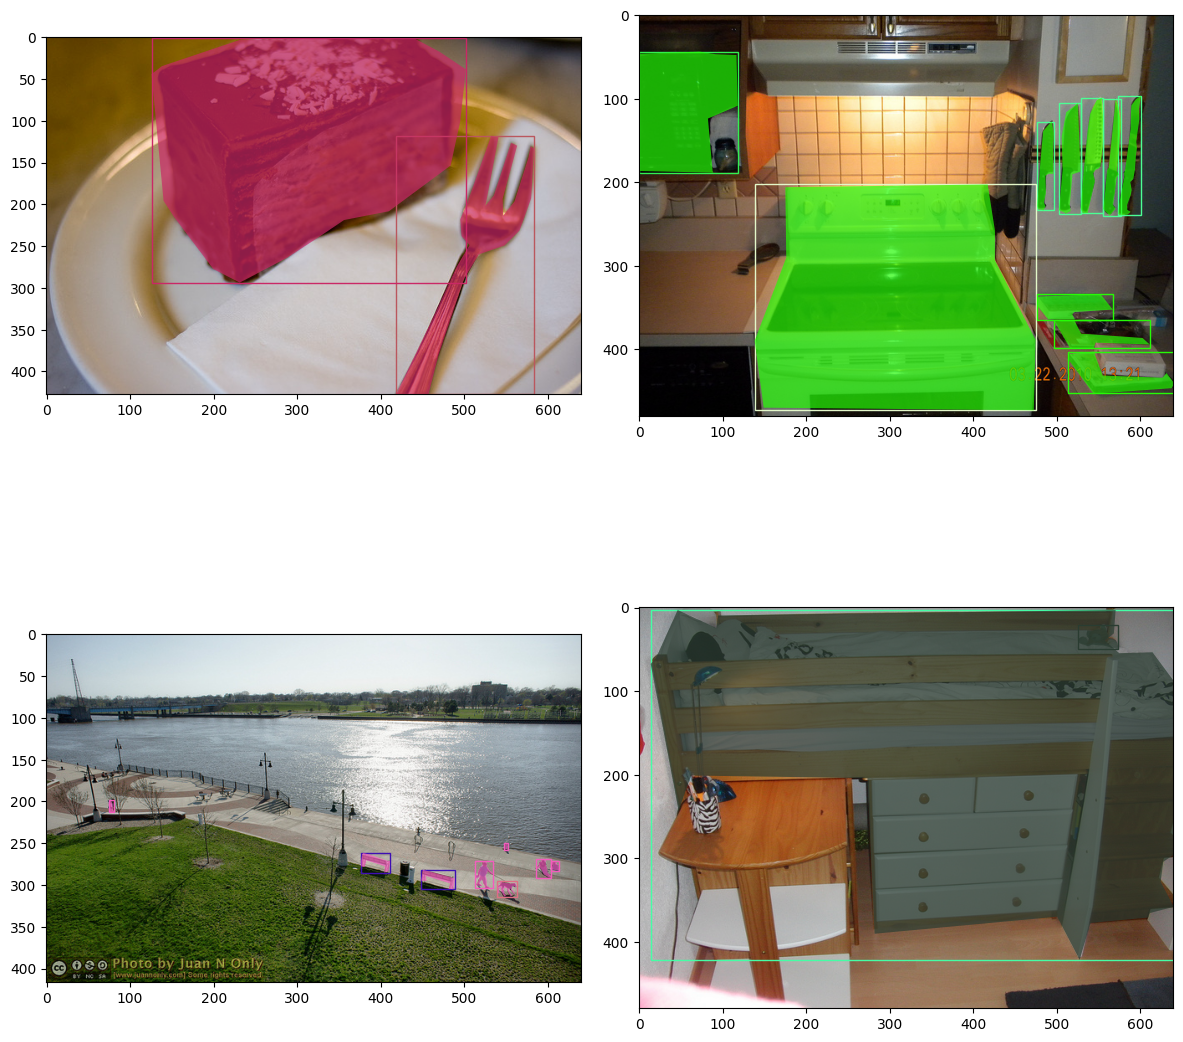

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

random.seed(1231243)


def plot_sample(img_index, ax):
    img = images_cpu.at(img_index)

    H = img.shape[0]
    W = img.shape[1]

    ax.imshow(img)
    bboxes = bboxes_cpu.at(img_index)
    labels = labels_cpu.at(img_index)
    polygons = polygons_cpu.at(img_index)
    vertices = vertices_cpu.at(img_index)
    categories_set = set()
    for label in labels:
        categories_set.add(label)

    category_id_to_color = dict(
        [
            (
                cat_id,
                [
                    random.uniform(0, 1),
                    random.uniform(0, 1),
                    random.uniform(0, 1),
                ],
            )
            for cat_id in categories_set
        ]
    )

    for bbox, label in zip(bboxes, labels):
        rect = patches.Rectangle(
            (bbox[0] * W, bbox[1] * H),
            bbox[2] * W,
            bbox[3] * H,
            linewidth=1,
            edgecolor=category_id_to_color[label],
            facecolor="none",
        )
        ax.add_patch(rect)

    for polygon in polygons:
        mask_idx, start_vertex, end_vertex = polygon
        polygon_vertices = vertices[start_vertex:end_vertex]
        polygon_vertices = polygon_vertices * [W, H]
        poly = patches.Polygon(
            polygon_vertices,
            facecolor=category_id_to_color[label],
            alpha=0.7,
        )
        ax.add_patch(
            poly,
        )


fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.tight_layout()
plot_sample(2, ax[0, 0])
plot_sample(1, ax[0, 1])
plot_sample(4, ax[1, 0])
plot_sample(8, ax[1, 1])
plt.show()